# 0. Imports

In [24]:
import os

import pandas as pd
import numpy as np

import torch ## torch let's us create tensors and also provides helper functions
import torch.nn as nn ## torch.nn gives us nn.Module(), nn.Embedding() and nn.Linear()
import torch.nn.functional as F # This gives us the softmax() and argmax()
from torch.optim import Adam ## We will use the Adam optimizer, which is, essentially, 
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo disponível: {device}")

import warnings
warnings.filterwarnings("ignore")

Dispositivo disponível: cuda


In [25]:
# Define a function to pad sequences to a specified length
def pad_sequences(sequences, max_len, pad_token):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < max_len:
            seq.extend([pad_token] * (max_len - len(seq)))
        padded_sequences.append(seq)
    return padded_sequences

# 1. Dataset

In [26]:
# Get current working directory
current_directory = os.getcwd()

df = pd.read_excel(current_directory+"\Porto_DB.xlsx").drop(columns=["Unnamed: 0","Fonte"],axis=1)[:11]

df["Final"] = df["Final"].apply(lambda x: x+" <EOS>")

df.head()

,Final
0,The Porto Tram Museum (Museu do Carro Eléctric...
1,The rabelo boat is a traditional Portuguese wo...
2,STCP (Sociedade de Transportes Colectivos do P...
3,The tram system of Porto in Portugal is operat...
4,"The FC Porto Museum, officially known as FC Po..."


# 2. Tokenizer

## 2.1. Data to Tokenize

In [4]:
df_token = pd.read_excel(current_directory+"\Porto_DB.xlsx").drop(columns=["Unnamed: 0","Fonte"],axis=1)

df_token = '\n'.join(df_token.astype(str).apply(lambda x: ' '.join(x), axis=1))


In [5]:
tokens = df_token.split()
unique_tokens = set([token.lower() for token in tokens])
tokens_to_id = {token: idx for idx, token in enumerate(unique_tokens)}
tokens_to_id['<PAD>'] = len(tokens_to_id)
tokens_to_id['<EOS>'] = len(tokens_to_id)

id_to_token = dict(map(reversed, tokens_to_id.items()))


In [6]:
# Initialize lists for inputs and outputs
inputs = []
labels = []

for t in range(df.shape[0]):
        inputs.append(df.iloc[t][0].split()[:-1])
        # print(t.split()[i:-1])
        labels.append(df.iloc[t][0].split()[1:])


final_inputs = []
final_labels = []

# Process each line to split into input and output
for inp, out in zip(inputs, labels):        
        tokenized_input = [ tokens_to_id[token.lower()] if token != '<EOS>' else tokens_to_id[token] for token in inp]
        final_inputs.append(tokenized_input)
        tokenized_labels = [tokens_to_id[token.lower()] if token != '<EOS>' else tokens_to_id[token] for token in out]
        final_labels.append(tokenized_labels)

padded_inputs = pad_sequences(final_inputs, 700, tokens_to_id['<PAD>'])
padded_labels = pad_sequences(final_labels, 700, tokens_to_id['<PAD>'])

# Convert to tensors
inputs = torch.tensor(final_inputs, dtype=torch.int64)
labels = torch.tensor(final_labels, dtype=torch.int64)

# 3. Batch

In [7]:
max_len=3000 #input
vocab_size = len(tokens_to_id)
d_model=2000
max_length = 20 #output

# 4. DataLoader - Prepare Dataset for Training

In [8]:
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

# 5. Embeddings

## 5.1. Class

In [9]:
class Embeddings(nn.Module):
    def __init__(self,vocab_size=vocab_size, d_model=d_model):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        embeddings = self.embeddings(x)
        return embeddings

## 5.2. Test Class

In [10]:
embeddings = Embeddings()
emb = embeddings(inputs[0])
emb

tensor([[ 0.4907,  0.5857, -2.0594,  ..., -0.5647, -0.0621, -0.5748],
        [ 0.1373,  0.2100, -0.5749,  ...,  0.1690,  1.0146,  0.2273],
        [ 0.7529, -0.8986,  0.6607,  ...,  0.2119, -1.0466,  1.0810],
        ...,
        [ 0.4859,  0.2394, -0.4297,  ..., -1.1283, -1.1729,  0.4656],
        [ 0.4859,  0.2394, -0.4297,  ..., -1.1283, -1.1729,  0.4656],
        [ 0.4859,  0.2394, -0.4297,  ..., -1.1283, -1.1729,  0.4656]],
       grad_fn=<EmbeddingBackward0>)

# 6. Positional Encodings

## 6.1. Class

In [11]:
class PositionEncoding(nn.Module):
    
    def __init__(self, d_model=d_model, max_len=max_len):        
        super().__init__()
       
        pe = torch.zeros(max_len, d_model)  
        position = torch.arange(start=0, end=max_len, step=1).float().unsqueeze(1)

        embedding_index = torch.arange(start=0, end=d_model, step=2).float()
        
        div_term = 1/torch.tensor(10000.0)**(embedding_index / d_model)
        
        pe[:, 0::2] = torch.sin(position * div_term) ## every other column, starting with the 1st, has sin() values
        pe[:, 1::2] = torch.cos(position * div_term) ## every other column, starting with the 2nd, has cos() values
      
        ## Now we "register 'pe'.
        self.register_buffer('pe', pe) ## "register_buffer()" ensures that
                                       ## 'pe' will be moved to wherever the model gets
                                       ## moved to. So if the model is moved to a GPU, then,
                                       ## even though we don't need to optimize 'pe', it will 
                                       ## also be moved to that GPU. This, in turn, means
                                       ## that accessing 'pe' will be relatively fast copared
                                       ## to having a GPU have to get the data from a CPU.

    def forward(self, word_embeddings):
        # print(word_embeddings.size())
        # print(self.pe[:word_embeddings.size(0), :].size())#[:word_embeddings.size(0), :])
        return word_embeddings.to(device) + self.pe[:word_embeddings.size(0), :].to(device) ## word_embeddings.size(0) = number of embeddings
                                                                      ## NOTE: That second ':' is optional and 
                                                                      ## we could re-write it like this: 
                                                                      ## self.pe[:word_embeddings.size(0)]

## 6.2. Test Class

In [12]:
PE = PositionEncoding()
pe_embeddings = PE(emb)
pe_embeddings

tensor([[ 0.4907,  1.5857, -2.0594,  ...,  0.4353, -0.0621,  0.4252],
        [ 0.9788,  0.7503,  0.2616,  ...,  1.1690,  1.0147,  1.2273],
        [ 1.6622, -1.3147,  1.5775,  ...,  1.2119, -1.0464,  2.0810],
        ...,
        [ 0.0658,  1.1468, -0.9443,  ..., -0.1308, -1.1026,  1.4632],
        [ 1.0225,  1.0832,  0.0055,  ..., -0.1308, -1.1025,  1.4632],
        [ 1.4859,  0.2437,  0.5619,  ..., -0.1308, -1.1024,  1.4632]],
       device='cuda:0', grad_fn=<AddBackward0>)

# 7. Self-Attention

## 7.1. Class

In [13]:
class Attention(nn.Module): 
    
    def __init__(self, d_model=d_model):     
        super().__init__()
        
        self.d_model=d_model
        self.W_q = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        self.W_k = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        self.W_v = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        
        self.row_dim = 0
        self.col_dim = 1

        
    def forward(self, pos_embeddings_q, pos_embeddings_k, pos_embeddings_v, mask=None):
        
        q = self.W_q(pos_embeddings_q)
        k = self.W_k(pos_embeddings_k)
        v = self.W_v(pos_embeddings_v)
        
        sims = torch.matmul(q, k.transpose(dim0=self.row_dim, dim1=self.col_dim))

        scaled_sims = sims / torch.tensor(k.size(self.col_dim)**0.5).to(device)

        if mask is not None:
            scaled_sims = scaled_sims.masked_fill(mask=mask.to(device), value=-1e9) 
        
        attention_percents = F.softmax(scaled_sims, dim=self.col_dim)

        # Scale the values by their associated percentages and add them up.
        attention_scores = torch.matmul(attention_percents, v)
        
        return attention_scores.to(device)

## 7.2. Test Class

In [14]:
attention = Attention().to(device)
attention(pe_embeddings,pe_embeddings,pe_embeddings)

tensor([[-0.2387, -0.3346,  0.0525,  ...,  0.1499, -0.0344, -0.1490],
        [-0.2534, -0.3475,  0.0639,  ...,  0.1342, -0.0056, -0.1763],
        [-0.3048, -0.3270,  0.0766,  ...,  0.1198, -0.0440, -0.1630],
        ...,
        [-0.2694, -0.3290,  0.0180,  ...,  0.1378, -0.0336, -0.2273],
        [-0.2710, -0.3263,  0.0114,  ...,  0.1371, -0.0279, -0.2307],
        [-0.2736, -0.3196,  0.0041,  ...,  0.1348, -0.0197, -0.2286]],
       device='cuda:0', grad_fn=<MmBackward0>)

# 8. DecoderOnlyTransformer

## 8.1 Class

In [15]:
torch.manual_seed(0)

class DecoderOnlyTransformer(nn.Module):
    
    def __init__(self, vocab_size=vocab_size, d_model=d_model, max_len=max_len):
        
        super().__init__()
        
        self.we = Embeddings(vocab_size, d_model)     
        
        self.pe = PositionEncoding(d_model=d_model, 
                                   max_len=max_len)

        self.self_attention = Attention(d_model=d_model)

        self.fc_layer = nn.Linear(in_features=d_model, out_features=vocab_size)
        
        self.loss = nn.CrossEntropyLoss()
        
        
    def forward(self, token_ids):
                
        word_embeddings = self.we(token_ids)     
        pe_embeddings = self.pe(word_embeddings)
        
        mask = torch.tril(torch.ones((token_ids.size(dim=0), token_ids.size(dim=0))))#, device=self.device))
        mask = mask == 0
        
        self_attention_values = self.self_attention(pe_embeddings, 
                                                    pe_embeddings, 
                                                    pe_embeddings, 
                                                    mask=mask)
        
        residual_connection_values = pe_embeddings + self_attention_values
        
        fc_layer_output = self.fc_layer(residual_connection_values)
        
        return fc_layer_output


## 8.2. Test Class

In [16]:
model = DecoderOnlyTransformer(vocab_size=len(tokens_to_id), d_model=d_model, max_len=max_len).to(device)
## Now create the input for the transformer...
model_input = torch.tensor([tokens_to_id["where"],
                            tokens_to_id["is"], 
                            tokens_to_id["porto"]]).to(device)

input_length = model_input.size(dim=0)

## Now get get predictions from the model
predictions = model(model_input) 
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])

predicted_ids = predicted_id


for i in range(input_length, max_length):
    if (predicted_id == tokens_to_id["<EOS>"]): # if the prediction is <EOS>, then we are done
        break
    
    model_input = torch.cat((model_input, predicted_id.to(device)))
    
    predictions = model(model_input) 
    predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
    predicted_ids = torch.cat((predicted_ids, predicted_id))
        
## Now printout the predicted output phrase.
answer = []
for id in predicted_ids: 
    answer.append(id_to_token[id.item()])

" ".join(answer)

"** produced. elizabeth's boutique! atenas. https://www.tripadvisor.com/commerce?url=https%3a%2f%2fwww.viator.com%2ftours%2fporto%2fcontrasts-of-porto-private-tour-classic-and-urban-art%2fd26879-24380p438%3feap%3dtripadvisor-main-11383%26aid%3dtripen1&partnerkey=1&urlkey=92d9dc9476a58eeb1&logme=true&uidparam=refid&attrc=true&provider=viator&area=viator_multi&slot=2&cnt=1&geo=12335869&clt=td&from=api&nt=true desenvolvido idade https://www.google.com/maps/search/?api=1&query=pneus%20campanh%c3%a3&query_place_id=chijjrg-zq9lja0rnmbwdcya-cq 4435-606 rp7shop, tempero ** rp7shop, tempero 2004.10.21) hydrate section'"

# 9. Treino

## 9.1. Batch - Treino

In [28]:
model = DecoderOnlyTransformer(vocab_size=len(tokens_to_id), d_model=d_model, max_len=max_len).to(device)
loss_fn = nn.CrossEntropyLoss(ignore_index=tokens_to_id['<PAD>'])
optimizer = Adam(model.parameters(), lr=0.0001)

## 9.2. Loop

Epoch 1/1000, Loss: 10.55411338806152343750
Epoch 2/1000, Loss: 7.67100334167480468750
Epoch 3/1000, Loss: 6.28117799758911132812
Epoch 4/1000, Loss: 5.36958885192871093750
Epoch 5/1000, Loss: 4.59946727752685546875
Epoch 6/1000, Loss: 4.11592864990234375000
Epoch 7/1000, Loss: 3.50509071350097656250
Epoch 8/1000, Loss: 3.41607713699340820312
Epoch 9/1000, Loss: 2.66239070892333984375
Epoch 10/1000, Loss: 2.40559411048889160156
Epoch 11/1000, Loss: 3.00578188896179199219
Epoch 12/1000, Loss: 2.43612122535705566406
Epoch 13/1000, Loss: 1.59133255481719970703
Epoch 14/1000, Loss: 1.94894814491271972656
Epoch 15/1000, Loss: 2.58057570457458496094
Epoch 16/1000, Loss: 2.47264575958251953125
Epoch 17/1000, Loss: 1.83323192596435546875
Epoch 18/1000, Loss: 1.13354933261871337891
Epoch 19/1000, Loss: 1.25606977939605712891
Epoch 20/1000, Loss: 1.60324418544769287109
Epoch 21/1000, Loss: 1.39860188961029052734
Epoch 22/1000, Loss: 0.84229350090026855469
Epoch 23/1000, Loss: 0.99469578266143798

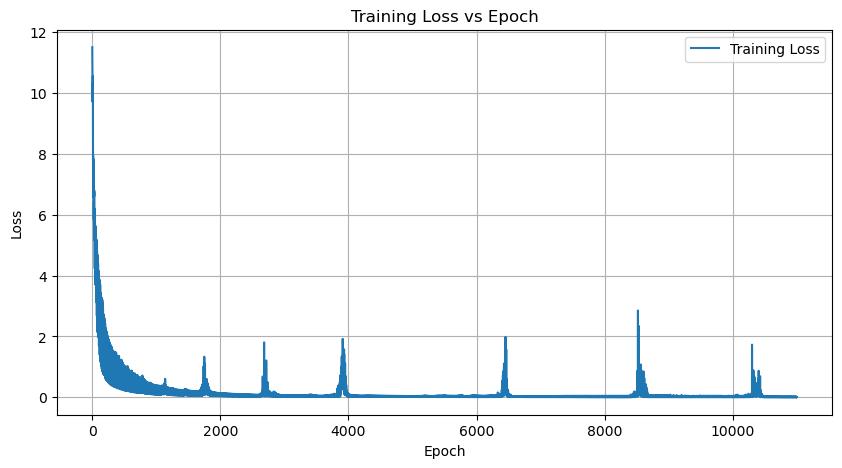

In [18]:
losses=[]
## Train the model
num_epochs = 1000

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in dataloader:
        inputs, labels = batch
        # print(inputs)
        # print(inputs.squeeze(0))
        ## Forward pass
        outputs = model(inputs.squeeze(0).to(device))
        # print(inputs.squeeze(0).size(),outputs.size(),labels.view(-1).size())
        # print(inputs.squeeze(0))
        # print(labels.view(-1))
        # print(outputs)
        
        ## Compute the loss
        loss = loss_fn(outputs.to(device), labels.view(-1).to(device))
        
        ## Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.to("cpu").detach().numpy())

    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss/len(inputs):.20f}')
    elif loss<0.00000000001:
        break


plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
# The Porto Tram Museum (Museu do Carro Eléctrico) is a museum operated by the Sociedade de Transportes Colectivos do Porto
# "The rabelo boat is a traditional Portuguese wooden cargo boat that was used for centuries to transport people and goods along the Douro River.  It is flat-bottomed, with a shallow draught, 
prompt = "The Porto Tram Museum (museu do carro eléctrico)"
prompt_listed = list(prompt.split())
for p in prompt_listed:
    prompt_tokenized = torch.tensor([tokens_to_id[token.lower()] for token in prompt_listed])


## Now get get predictions from the model
predictions = model(prompt_tokenized.to(device)) 
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
predicted_ids = predicted_id
max_length=250
for i in range(max_length):

    if (predicted_id == tokens_to_id["<EOS>"]): # if the prediction is <EOS>, then we are done
        break
    
    prompt_tokenized = torch.cat((prompt_tokenized, predicted_id))
    
    predictions = model(prompt_tokenized.to(device)) 
    predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
    predicted_ids = torch.cat((predicted_ids, predicted_id))
        
## Now printout the predicted output phrase.
answer = []
for id in predicted_ids: 
    answer.append(id_to_token[id.item()])

# The rabelo boat is a traditional Portuguese wooden cargo boat that was used for centuries to transport people and goods along the Douro River.  It is flat-bottomed, with a shallow draught, which was necessary to navigate the often shallow fast-flowing waters of the upper Douro prior to the construction of dams and locks from 1968 onwards.
print("Training Set: "+ "The Porto Tram Museum (Museu do Carro Eléctrico) is a museum operated by the Sociedade de Transportes Colectivos do Porto. It was inaugurated in 1992 and is installed \nin a former thermoelectric power station next to the River Douro in Massarelos, Porto, Portugal. It exhibits material related to the history of trams in Porto.")
print("--------------------")
print("Prompt: "+prompt)
print("--------------------")
print("Cahtbot Answer: "+" ".join(answer))

Training Set: The Porto Tram Museum (Museu do Carro Eléctrico) is a museum operated by the Sociedade de Transportes Colectivos do Porto. It was inaugurated in 1992 and is installed 
in a former thermoelectric power station next to the River Douro in Massarelos, Porto, Portugal. It exhibits material related to the history of trams in Porto.
--------------------
Prompt: The Porto Tram Museum (museu do carro eléctrico)
--------------------
Cahtbot Answer: is a museum operated by the sociedade de transportes colectivos do porto. it was inaugurated in 1992 and is installed in a former thermoelectric power station next to the river douro in massarelos, porto, portugal. it exhibits material related to the history of trams in porto. the collection contains 16 electric cars, 5 trailers, and two maintenance vehicles as well as the former equipment of the power plant, which provided electricity for the tram lines. == the building == the construction of the building as a power plant was completed 

# 10. Save the Model

In [27]:
model_path = "simple_model.pth"

In [22]:

torch.save(model.state_dict(), model_path)

# Para também salvar o otimizador e outras informações
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}
torch.save(checkpoint, "simple_model_checkpoint.pth")

# 11. Load the Model

In [29]:
# Carregando o modelo
loaded_model = DecoderOnlyTransformer().to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()  # Coloca o modelo em modo de avaliação

# Para carregar o checkpoint completo
checkpoint = torch.load("simple_model_checkpoint.pth")
loaded_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
loss = checkpoint['loss']

# Confirme que os estados foram carregados corretamente
print(loaded_model)
print(optimizer)
print(f"Start epoch: {start_epoch}")
print(f"Loss: {loss}")

DecoderOnlyTransformer(
  (we): Embeddings(
    (embeddings): Embedding(74732, 2000)
  )
  (pe): PositionEncoding()
  (self_attention): Attention(
    (W_q): Linear(in_features=2000, out_features=2000, bias=False)
    (W_k): Linear(in_features=2000, out_features=2000, bias=False)
    (W_v): Linear(in_features=2000, out_features=2000, bias=False)
  )
  (fc_layer): Linear(in_features=2000, out_features=74732, bias=True)
  (loss): CrossEntropyLoss()
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Start epoch: 999
Loss: 0.003954051062464714


## 11.1. Test Loaded Model

In [30]:
prompt = "The Porto Tram Museum (museu do carro eléctrico) is a museum operated"
prompt_listed = list(prompt.split())
for p in prompt_listed:
    prompt_tokenized = torch.tensor([tokens_to_id[token.lower()] for token in prompt_listed])


## Now get get predictions from the model
predictions = loaded_model(prompt_tokenized.to(device))
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
predicted_ids = predicted_id
max_length=1000
for i in range(max_length):

    if (predicted_id == tokens_to_id["<EOS>"]): # if the prediction is <EOS>, then we are done
        break
    
    prompt_tokenized = torch.cat((prompt_tokenized, predicted_id))
    
    predictions = loaded_model(prompt_tokenized.to(device)) 
    predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
    predicted_ids = torch.cat((predicted_ids, predicted_id))
        
## Now printout the predicted output phrase.
answer = []
for id in predicted_ids: 
    answer.append(id_to_token[id.item()])

# The rabelo boat is a traditional Portuguese wooden cargo boat that was used for centuries to transport people and goods along the Douro River.  It is flat-bottomed, with a shallow draught, which was necessary to navigate the often shallow fast-flowing waters of the upper Douro prior to the construction of dams and locks from 1968 onwards.
print("The Porto Tram Museum (Museu do Carro Eléctrico) is a museum operated by the Sociedade de Transportes Colectivos do Porto. It was inaugurated in 1992 and is installed \nin a former thermoelectric power station next to the River Douro in Massarelos, Porto, Portugal. It exhibits material related to the history of trams in Porto.")
print(prompt)
" ".join(answer)

The Porto Tram Museum (Museu do Carro Eléctrico) is a museum operated by the Sociedade de Transportes Colectivos do Porto. It was inaugurated in 1992 and is installed 
in a former thermoelectric power station next to the River Douro in Massarelos, Porto, Portugal. It exhibits material related to the history of trams in Porto.
The Porto Tram Museum (museu do carro eléctrico) is a museum operated


'by the sociedade de transportes colectivos do porto. it was inaugurated in 1992 and is installed in a former thermoelectric power station next to the river douro in massarelos, porto, portugal. it exhibits material related to the history of trams in porto. the collection contains 16 electric cars, 5 trailers, and two maintenance vehicles as well as the former equipment of the power plant, which provided electricity for the tram lines. == the building == the construction of the building as a power plant was completed in 1915. it consists of two large halls that were, respectively, the hall for the steam generators (boilers) and the engine room. until the 1940s the power station produced enough energy to power the tram network. however, with the increase in the number of electric cars in circulation, the trams became partially dependent on the city\'s power supply and serafim teixeira. it was felt in the plant ceased, although it continues to operate as a substation for the three remain

# 12. Test New Embeddings

In [31]:
a = embeddings(torch.tensor(tokens_to_id["671."])).detach().numpy()
b = embeddings(torch.tensor(tokens_to_id["751."])).detach().numpy()

matrix = [a, b]
cosine_similarity(matrix),np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

(array([[ 0.9999998 , -0.00338529],
        [-0.00338529,  1.0000002 ]], dtype=float32),
 -0.0033852896)

In [35]:
a = model.to("cpu").we(torch.tensor(tokens_to_id["671."])).detach().numpy()
b = model.to("cpu").we(torch.tensor(tokens_to_id["751."])).detach().numpy()

matrix = [a, b]
cosine_similarity(matrix),np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

(array([[ 0.9999997 , -0.01389037],
        [-0.01389037,  0.9999997 ]], dtype=float32),
 -0.01389036)